# Viga de Euler-Bernoulli

Exemplo baseado na documentação e em livros de Mecânica do Sólidos  
**Notebook por:** Paulo de Souza Silva  
**Data:** Julho de 2025  
**Notebook modificado por:** Renato Cesar de Carvalho


**IGNORE ESTE CÓDIGO INICIAL**

* Se a figura da viga não aparecer, basta rodá-lo.


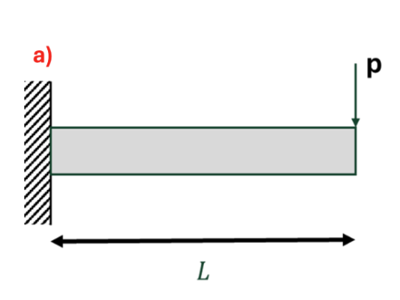

In [ ]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1RE3dXUdSqu2zU_j37et4TX5VGG207gUQ'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (400, 300)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)

## Obtenção da Solução Analítica

A viga engastada com carga distribuída é um problema comum da formulação de Euler-Bernoulli, cujo o formalismo matemático (Gere,2003; Beer, 2017) pode ser expresso por:

$$EI\frac{d^4y}{dx^4} = - w(x)$$

considerando o carregamento para baixo **positivo**.

Por ser uma equação diferencial de quarta ordem a mesma exige quatro condições para ser resolvida.

Das considerações de **força cortante** e **momento fletor**, temos que **nessa configuração da Figura**:
$$V(x) = p \hspace{2cm} M(x) = -px$$

Para o formalismo adotado, temos que:
$$EI\frac{d^3y}{dx^3} = V(x) \hspace{2cm} EI\frac{d^2y}{dx^2} = M(x)$$

Com isso em mente, podemos resolver a EDO de quarta ordem, basta aplicarmos uma integral quatro vezes e depois considerar as condições.



### Calculation of equation of the elastic curve

$$EIy'' = M(x) = -p(L-x)=-pL+px$$
$$EIy' = \frac{px^2}{2}-pLx+C_1$$
$$y' = 0 \hspace{0.5cm} at \hspace{0.5cm} x = 0$$
$$EI0 = \frac{p0^2}{2}-pL0+C_1$$
$$C_1=0$$
$$EIy' = \frac{px^2}{2}-pLx$$
$$EIy = \frac{px^3}{6}-\frac{pLx^2}{2}+C_2$$
$$y = 0 \hspace{0.5cm} at \hspace{0.5cm} x = 0$$
$$EI0 = \frac{p0^3}{6}-\frac{pL0^2}{2}+C_2$$
$$C_2=0$$
$$EIy = \frac{px^3}{6}-\frac{pLx^2}{2}$$
$$y = \frac{px^3}{6EI}-\frac{pLx^2}{2EI} = \frac{p}{6EI}(x^3 - 3Lx^2)$$

> **Obs:** É preciso ter muito cuidado com relação aos sinais (que devem ser adotados de maneira coerente), em algumas literaturas  é possível encontrar:
$$EI\frac{d^4y}{dx^4} = w(x)$$
nesse caso, assume-se que o carregamento para baixo é **negativo**

**referências**  
Beer, F., E. Johnston, J. DeWolf and D. Mazurek. Mechanics of Materials, 7e in SI Units. Stress 1.11 (2017): 1-12.  
Gere, J. M. Mecânica dos Materiais, Editora Thomson Learning. 2003.

## Resolução da Viga com DeepXDE

**instalar o DeepXDE no Colab**

[Installation DeepXDE](https://deepxde.readthedocs.io/en/latest/user/installation.html)

* Para instalar no Colab, usamos antes do `pip` o símbolo `!`
* Para a célula ficar limpa ao fim da instalação adicionamos o `-q` entre o `install` e o nome da biblioteca

In [ ]:
! pip install -q deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.7 MB/s eta 0:00:00


**bibliotecas principais**

* Aqui chamamos as bibliotecas principais que são padrões como `numpy` e o `matplotlib`
* Além delas, é claro, vamos chamar o `deepxde`; como ele tem como backends o `tensorflow, pytorch, jax` e o `paddle` uma dessas também tem que ser chamada, escolheremos o pytorch.
* Devemos dizer ao DeepXDE que o pytorch será nosso backend e usamos o comando `backend.backend_name`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch
dde.backend.backend_name = "pytorch"

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


**parâmetros do problema**

In [ ]:
# Updated parameters with consistent units and force in MN, E in MN/m²
L = 3  # meters (m)
E = 2.1e8  # kilonewtons per square meter (kN/m²)
I = 6.51e-5  # meters to the fourth (m^4)
p = 16  # kilonewtons (kN)
EI=E*I
w = 0

**solucao analitica**

In [ ]:
def func(x):
    term_1 = (p * (x ** 3)) / (6 * E * I)
    term_2 = (p * L * (x ** 2)) / (2 * E * I)
    return term_1 - term_2

# Verifique a solução exata para x = 300 cm
x_test = 3
y_exact = func(x_test)
print("Solução exata para x = 3 m:", y_exact)


Solução exata para x = 3 m: -0.010533245556287032


**Definindo o Intervalo**

Como temos um problema 1D, podemos definir o intervalo com auxílio da **classe** `geometry`
* `geometry.geometry_1d.Interval(l,r)`

em que l é o valor a esquerda e r o valor a direita (no nosso caso a origem até o comprimento da viga)

In [ ]:
geom = dde.geometry.geometry_1d.Interval(0, L)

### Derivadas Uteis e Definicao da EDO do problema

Como estamos usando o Pytorch, podemos fazer as derivadas considerando o uso da classe `grad` (remete a gradiente e as funções autograd, internas as bibliotecas como o próprio Pytorch, TensorFlow etc)

A estratégia é, calcular a derivada segunda e a derivada terceira em um primeiro momento, para serem usadas nas condições de contorno.

Para isso usamos as opções `grad.hessian` e `grad.jacobian`

> **1. JACOBIANO**
* Para um função escalar $f(x)$, o Jacobiano é simplemente a **primeira derivada** com respeito a variável  
$$\frac{df}{dx}$$
* Para um função multivariável $f(x,y)$ em 2D, o Jacobiano é um vetor de derivadas parciais com relação a cada variável.  
$$J = \begin{bmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{bmatrix}$$

> **2. HESSIANO**
* O Hessiano é uma matriz de derivadas parciais de segunda ordem;
* Para um função escalar $f(x)$ em 1D, é apenas a **segunda derivada** com respeito a $x$.
$$\frac{d^2f}{dx^2}$$
* Para um função multivariável $f(x,y)$ em 2D, é uma matriz que inclui todos derivaradas de segunda ordem possível.
$$H = \begin{bmatrix}
\frac{\partial^2f}{\partial x^2} & \frac{\partial ^2f}{\partial x \partial y} \\
\frac{\partial^2f}{\partial y \partial x} & \frac{\partial^2f}{\partial y^2}
\end{bmatrix}$$

**Ver vídeo:** [DeepXDE Tutorial 2](https://youtu.be/Nsf5bmI54oc?si=gkTdPnNFhr7ZWYDi)

Uma estratégia similar decorre para a EDO do nosso problema, que tem derivada de 4 ordem.

In [ ]:
# Derivadas de Ordem 2
def ddy(x, y):
    return dde.grad.hessian(y, x)

# Derivada de Ordem 1 da Derivada de Ordem 2 (3 Derivada)
def dddy(x, y):
    return dde.grad.jacobian(ddy(x, y), x)

def ddddy(x, y):
    # Chamando a funcao da derivada segunda
    dy_xx = ddy(x, y)
    return dde.grad.hessian(dy_xx, x)

In [ ]:
# Definicao da EDO do problema
def pde(x, y):
    d2y_dx = ddy(x, y)
    return (d2y_dx+(p*(L-x))/(E*I))

### Condições de Contorno

Como estamos trabalhando em um problema 1D, os pontos de teste que usamos são sempre conferidos somente **um de cada vez** tornando-se **um ponto** do domínio, logo:
* Se estamos olhando **na esquerda do domínio** `x[0]`$\approx$ `0`
* Se estamos olhando **na direita do domínio** `x[0]`$\approx$ `L`

Se o dominio fosse bi-dimensional, **cada ponto** teria **duas coordendas** `x[0]` e `x[1]`

Dessa forma e pra evitar erros numéricos, podemos definir que:
* o contorno a esquerda (`boundary_l`) e
* a direita (`boundary_r`)

podem ser definidos como segue, em que retornam um valor verdadeiro para:
* `x[0]` próximo a zero e
* `x[0]` próximo a L.

Já o `on_boundary` é um **booleano** que o próprio DeepXDE vai definir para que a avaliação seja de fato feita **somente na fronteira**.

In [ ]:
def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)

Seguindo com relação as condições de contorno, como definidos de fato quais pontos são nas fronteiras, podemos declarar as quatro condições:
* bc1 - $y$ em x = 0 deve ser nula (**condição de Dirichlet**)
* bc2 - $dy/dx$ em x = 0 deve ser nula (**condição de Neumann**)

* Para bc1 e bc2 existem duas classes específicas **`icbc.DirichletBC`** e **`icbc.NeumannBC`**.

In [ ]:
bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)

### Dados para o DeepXDE
[Modulo data.pde](https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html#module-deepxde.data.pde)

Agora que temos a nossa equação diferencial e as condições de contorno, definimos o conjunto de **"dados"** para nossa rede, na ocasião devemos usar o módulo `data.PDE` dentro dele chamamos e definimos:
* `geometry` - geometria
* `pde` - equação diferencial
* `bcs` - as condições de contorno
* `num_domain` número inteiro de pontos dentro do domínio para o **treinamento**
* `num_boundary` número inteiro de pontos de **treino** na fronteira
* `num_test` número inteiro de pontos de **teste**

Outras coisas podem ser definidas, como: **tipo de distribuição** para os dados de treinamento, dados de uma **solução de referência** etc

In [ ]:
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2],
    num_domain=50,
    num_boundary=4,
    solution=func,
    num_test=100,
)

In [ ]:
# data = dde.data.PDE(
#     geom,
#     pde,
#     [bc1, bc2, bc3, bc4],
#     num_domain=10,
#     num_boundary=2,
#     solution=func,
#     num_test=100,
# )

### Criação da Rede
[PytorchFNN](https://deepxde.readthedocs.io/en/latest/modules/deepxde.nn.pytorch.html#module-deepxde.nn.pytorch.fnn)

Agora, precisamos definir o **formato** da nossa rede, sua **função de ativação**, o **tipo de inicializador** dos pesos e vieses etc:

* Vamos adotar **1 entrada**, **1 saída** e **3 camadas ocultas** com **20 neurônios**
* rede Fully-Connected (FNN)
* Nossa função de ativação será a **tangente hiperbólica `tanh`**
* A função de inicialização de pesos será a **`Glorot uniform`**

In [ ]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

### Modelo e Otimização
Com os **dados** e o **formato da rede definidos**, montamos nosso **modelo** e colocamos ele para **otimizar/treinar**.

* Para definir o modelo usamos o **classe** `Model(data,net)`
* A esse modelo definimos configurações para o treino como:
  * **Otimizador:** (Adam, BFGS)
  * **Taxa de aprendizado** (*lr*)
  * **metricas:** são métricas desejadas para serem calculadas durante o treino, pode ser usada quando existem dados iniciais

Com esses parâmetros definidos, podemos treinar o modelo, sendo possível definir:
* `iterations`: número de iterações (épocas)
* `batch_size`:
* `display_every`: a cada quantas épocas deve ser printado o avanço (padrão é 1000)  

Como retorno tem *losshistory* e *train_state*

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
#model.compile("adam", lr=0.001)
N_iter = 5000
step = 200
losshistory, train_state = model.train(iterations=N_iter,display_every=step)

Compiling model...
Building feed-forward neural network...
'build' took 0.077760 s

'compile' took 0.613264 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.48e-02, 0.00e+00, 1.72e-01]    [1.56e-02, 0.00e+00, 1.72e-01]    [1.01e+02]    
200       [5.67e-07, 2.48e-10, 1.76e-08]    [5.56e-07, 2.48e-10, 1.76e-08]    [9.55e-02]    
400       [1.51e-08, 5.01e-14, 9.69e-12]    [1.55e-08, 5.01e-14, 9.69e-12]    [1.40e-02]    
600       [9.61e-09, 8.74e-15, 1.54e-12]    [8.80e-09, 8.74e-15, 1.54e-12]    [1.05e-02]    
800       [8.43e-09, 4.84e-16, 3.49e-13]    [6.84e-09, 4.84e-16, 3.49e-13]    [8.82e-03]    
1000      [8.16e-09, 7.89e-15, 1.83e-14]    [6.29e-09, 7.89e-15, 1.83e-14]    [8.12e-03]    
1200      [8.01e-09, 8.34e-16, 5.27e-14]    [6.10e-09, 8.34e-16, 5.27e-14]    [7.89e-03]    
1400      [7.86e-09, 2.27e-14, 6.72e-15]    [5.98e-09, 2.27e-14, 6.72e-15]    [7.72e-03]    
1600      [7.73e-09, 6.97e-11, 2.

**graficos**

Para avaliar os resultados finais, vamos definir:
* Um vetor no eixo x para PINN
* Um vetor no eixo x para solução exata
* Calcular o valor predito pela PINN
* Calcular o valor exato
* Plotar os gráficos das soluções em conjunto

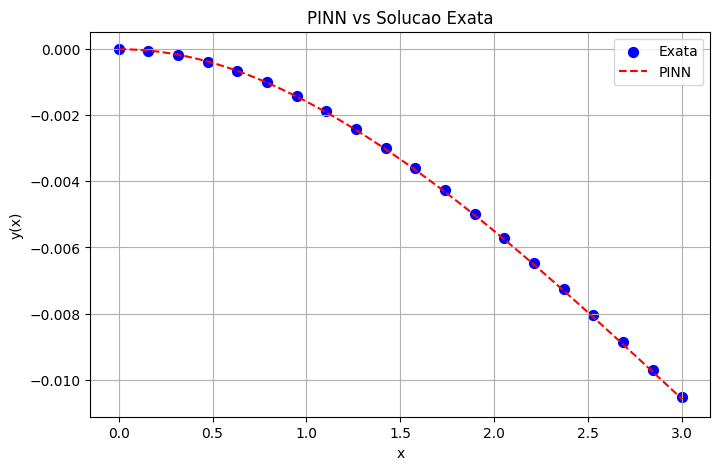

In [ ]:
## Definindo X_PINN e Y_PINN
x_pinn = np.linspace(0,3,100).reshape(-1,1)
y_pinn = model.predict(x_pinn)

# Calculo da solucao exata
x_exato = np.linspace(0,3,20).reshape(-1,1)
y_exato = func(x_exato)

# Plotando a PINN vs a solucao exata
plt.figure(figsize=(8,5))
plt.scatter(x_exato, y_exato, label = 'Exata', color = 'blue', marker = "o", s = 50)
plt.plot(x_pinn, y_pinn, label = 'PINN', color = "red", linestyle = "--")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("PINN vs Solucao Exata")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Curva da funçoes de perda da PDE, ICBCs e Total
losses = np.array(losshistory.loss_train)
print(np.shape(losses))
pde_loss_plot = losses[:,0]
icbc_loss_plot = np.array(np.sum(losses[:,1:],1))
print(np.shape(icbc_loss_plot))
total_loss_plot = pde_loss_plot + icbc_loss_plot

(26, 3)
(26,)


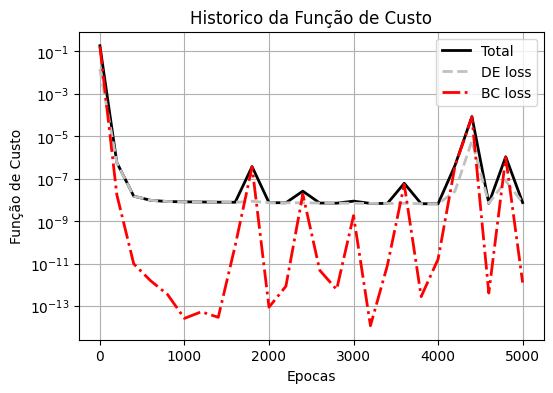

In [ ]:
plt.figure(figsize=(6,4))
epocas = np.linspace(0,N_iter,np.size(pde_loss_plot))
plt.plot(epocas,total_loss_plot, 'k', linewidth=2, label="Total")
plt.plot(epocas,pde_loss_plot, color='silver', linestyle='--', linewidth=2, label="DE loss")
plt.plot(epocas,icbc_loss_plot, color='r', linestyle='-.', linewidth=2, label="BC loss")

plt.xlabel('Epocas')
plt.ylabel('Função de Custo')
plt.yscale('log')
plt.title('Historico da Função de Custo')
plt.legend()
plt.grid(True)
plt.show()